<center><h1>DSCI-552 HOMEWORK 5</h1>
<br>
<font size="3">Name: Vorapoom Thirapatarapong</font>
<br>
<font size="3">USC ID: 4397330150 Github Username: bvorapoom</font></center>

#### import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from skmultilearn.problem_transform import LabelPowerset
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import xgboost as xgb
import statsmodels.api as sm

# 1. Decision Trees as Interpretable Models

#### load dataset

In [2]:
col_name_diag = ['temp_patient', 'occ_nausea', 'lumbar_pain', 'urine_pushing', 'micturition_pain', \
                 'burning', 'd_inflammation', 'd_nephritis']
df_diag = pd.DataFrame(columns = col_name_diag)

with open('../data/diagnosis.data', 'rb') as f:
    temp_file = f.read().decode('utf-16')
    temp_file = temp_file.split('\r\n')
    for line in temp_file:
        if line == '':
            continue
        temp_vals = line.split('\t')
        temp_vals[0] = float(temp_vals[0].replace(',', '.'))
        df_diag.loc[len(df_diag), :] = temp_vals
  

print(df_diag.shape, df_diag.head(), sep = '\n')


(120, 8)
  temp_patient occ_nausea lumbar_pain urine_pushing micturition_pain burning  \
0         35.5         no         yes            no               no      no   
1         35.9         no          no           yes              yes     yes   
2         35.9         no         yes            no               no      no   
3         36.0         no          no           yes              yes     yes   
4         36.0         no         yes            no               no      no   

  d_inflammation d_nephritis  
0             no          no  
1            yes          no  
2             no          no  
3            yes          no  
4             no          no  


### 1-b Build a decision tree on the whole data set and plot it.

In [3]:
# map yes/no values to 1/0
df_diag.loc[:, df_diag.columns != 'temp_patient'] = df_diag.loc[:, df_diag.columns != 'temp_patient'].replace({'yes' : 1, 'no' : 0})
df_diag = df_diag.astype(float)

# separate X and y
df_diag_X = df_diag.loc[:, [col not in ['d_inflammation', 'd_nephritis'] for col in df_diag.columns]]
df_diag_y = df_diag.loc[:, ['d_inflammation', 'd_nephritis']]


In [4]:
# convert multiple labels to 1 multiclass label using LabelPowerset

pws = LabelPowerset()
df_diag_y_trans = pws.transform(df_diag_y)

# see mapping of new label to previous multilabel
label_concat = pd.concat([df_diag_y, pd.DataFrame(df_diag_y_trans, columns = ['new_label'])], axis = 1)
print('new mapping of labels: \n', label_concat.drop_duplicates())


new mapping of labels: 
     d_inflammation  d_nephritis  new_label
0              0.0          0.0          0
1              1.0          0.0          1
60             0.0          1.0          2
70             1.0          1.0          3


In [5]:
# train decision tree on entire data
cls_tree = DecisionTreeClassifier(random_state = 0)
cls_tree.fit(df_diag_X, df_diag_y_trans)

DecisionTreeClassifier(random_state=0)

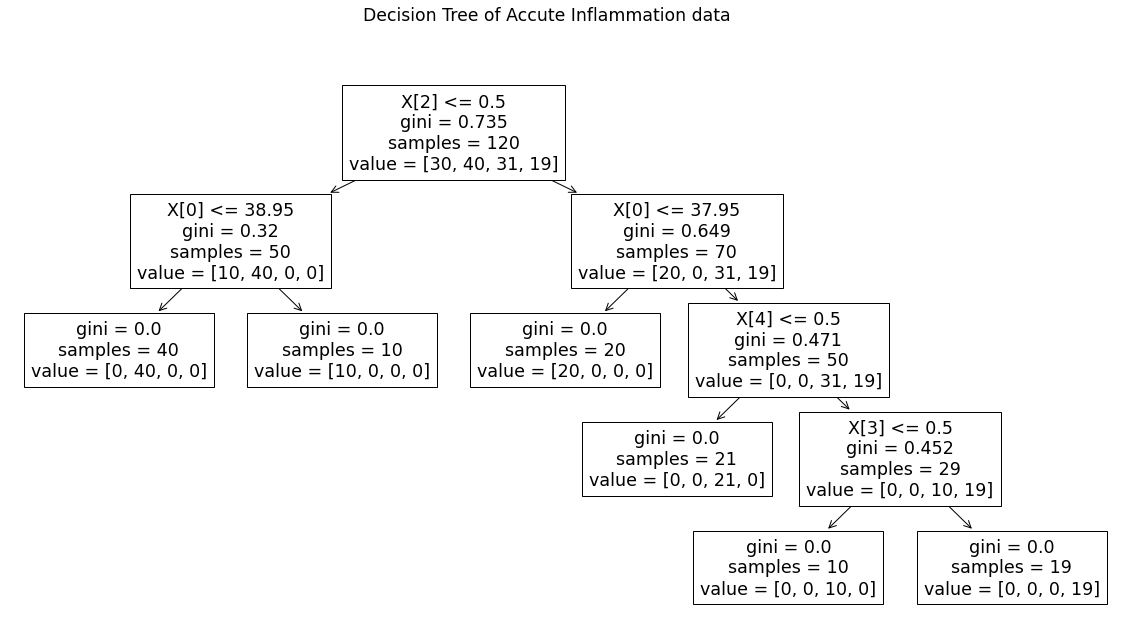

In [6]:
# plot the trained decision tree
plt.figure(figsize = (20, 10))
plot_tree(cls_tree)
plt.suptitle('Decision Tree of Accute Inflammation data', fontsize = 'xx-large')
plt.show()

### 1-c Convert the decision rules into a set of IF-THEN rules.

In [7]:
# code for converting tree to if-then rules from https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html

def tree_to_pseudo(tree, feature_names):
    '''
    Outputs a decision tree model as if/then pseudocode
    
    Parameters:
    -----------
    tree: decision tree model
        The decision tree to represent as pseudocode
    feature_names: list
        The feature names of the dataset used for building the decision tree
    '''
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [8]:
tree_to_pseudo(cls_tree, df_diag_X.columns)

 if ( lumbar_pain <= 0.5 ) {
   if ( temp_patient <= 38.95000076293945 ) {
     return [[ 0. 40.  0.  0.]]
   } else {
     return [[10.  0.  0.  0.]]
   }
 } else {
   if ( temp_patient <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     if ( micturition_pain <= 0.5 ) {
       return [[ 0.  0. 21.  0.]]
     } else {
       if ( urine_pushing <= 0.5 ) {
         return [[ 0.  0. 10.  0.]]
       } else {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


### 1-d Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [9]:
# try different alphas to see impurities
cls_temp = DecisionTreeClassifier(random_state = 0)
path = cls_temp.cost_complexity_pruning_path(df_diag_X, df_diag_y_trans)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

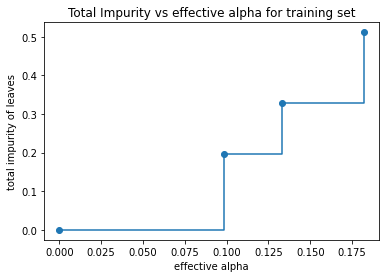

In [10]:
# plot impurities vs different alpha values
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker = "o", drawstyle = "steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

#### Perform 5-fold CV in order to find the best minimal tree (highest acc)

In [11]:
params = {'ccp_alpha' : [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
cls_dt = DecisionTreeClassifier()
cls_dt_cv = GridSearchCV(cls_dt, params, cv = 5, scoring = 'accuracy')
cls_dt_cv.fit(df_diag_X, df_diag_y_trans)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                                       0.35]},
             scoring='accuracy')

In [12]:
cls_dt_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0)

In [13]:
# best minimal? decision tree with alpha = 0
cls_min_tree = DecisionTreeClassifier(random_state = 0, ccp_alpha = 0)
cls_min_tree.fit(df_diag_X, df_diag_y)

DecisionTreeClassifier(ccp_alpha=0, random_state=0)

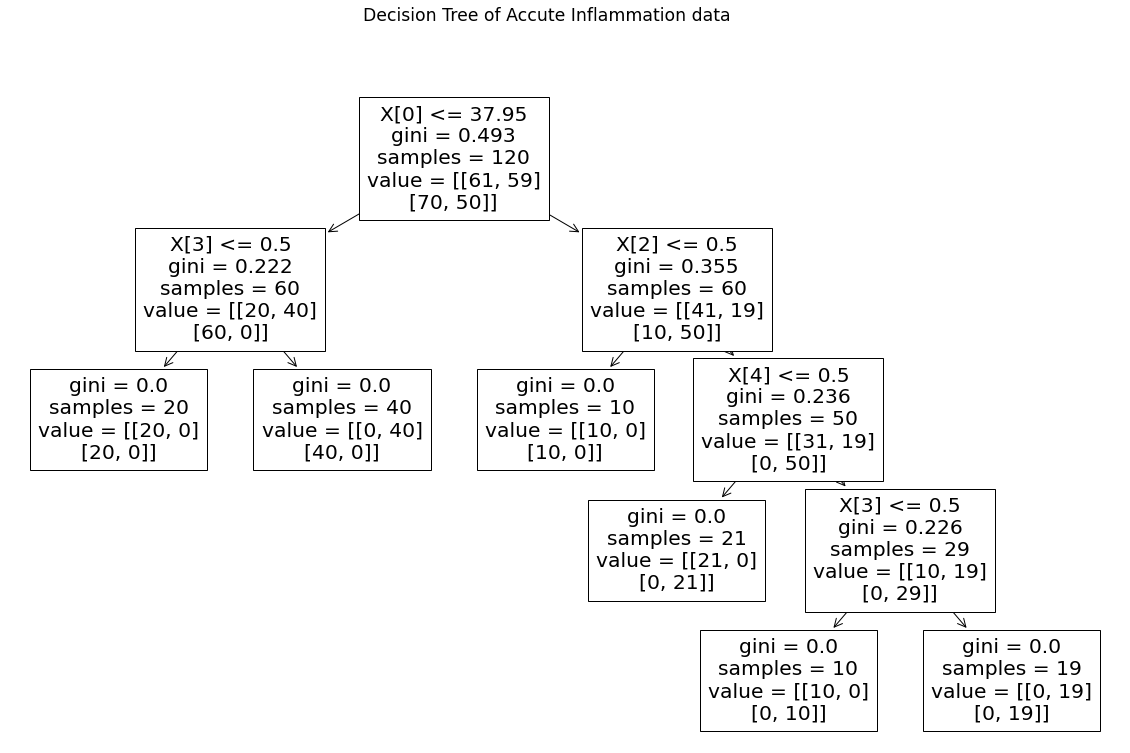

In [14]:
# plot the trained minimal decision tree (same as full-grown tree as alpha = 0)
plt.figure(figsize = (20, 12))
plot_tree(cls_min_tree)
plt.suptitle('Decision Tree of Accute Inflammation data', fontsize = 'xx-large')
plt.show()

In [15]:
# IF-THEN decision rule for the minimal tree
tree_to_pseudo(cls_min_tree, df_diag_X.columns)

 if ( temp_patient <= 37.95000076293945 ) {
   if ( urine_pushing <= 0.5 ) {
     return [[20.  0.]
 [20.  0.]]
   } else {
     return [[ 0. 40.]
 [40.  0.]]
   }
 } else {
   if ( lumbar_pain <= 0.5 ) {
     return [[10.  0.]
 [10.  0.]]
   } else {
     if ( micturition_pain <= 0.5 ) {
       return [[21.  0.]
 [ 0. 21.]]
     } else {
       if ( urine_pushing <= 0.5 ) {
         return [[10.  0.]
 [ 0. 10.]]
       } else {
         return [[ 0. 19.]
 [ 0. 19.]]
       }
     }
   }
 }


#### best minimal tree that is actually pruned (using alpha = 0.1)

In [16]:
# best minimal tree (that is actually pruned) when using alpha = 0.1
cls_min_tree_2 = DecisionTreeClassifier(random_state = 0, ccp_alpha = 0.1)
cls_min_tree_2.fit(df_diag_X, df_diag_y)

DecisionTreeClassifier(ccp_alpha=0.1, random_state=0)

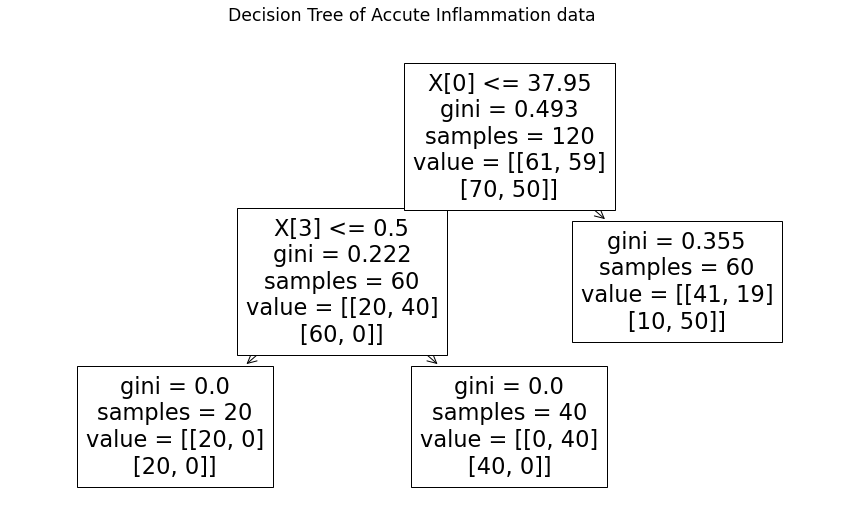

In [17]:
# plot the trained minimal decision tree (pruned tree with alpha = 0.1)
plt.figure(figsize = (15, 8))
plot_tree(cls_min_tree_2)
plt.suptitle('Decision Tree of Accute Inflammation data', fontsize = 'xx-large')
plt.show()

In [18]:
# IF-THEN decision rule for the minimal tree (alpha = 0.1)
tree_to_pseudo(cls_min_tree_2, df_diag_X.columns)

 if ( temp_patient <= 37.95000076293945 ) {
   if ( urine_pushing <= 0.5 ) {
     return [[20.  0.]
 [20.  0.]]
   } else {
     return [[ 0. 40.]
 [40.  0.]]
   }
 } else {
   return [[41. 19.]
 [10. 50.]]
 }


# 2. The LASSO and Boosting for Regression

#### load dataset

In [19]:
# loading dataset column names
col_name_crime = []
with open('../data/communities.names') as f:
    for line in f:
        if line.startswith('@attribute'):
            col_name = re.search('@attribute\s(.*?)\s\w+', line).group(1)
            col_name_crime.append(col_name)

# loading dataset
df_crime = pd.read_csv('../data/communities.data', names = col_name_crime, na_values = ['?'])
print(df_crime.head())


# split into training and testing set
df_crime_train = df_crime.loc[:1494, :]
df_crime_test = df_crime.loc[1495:, :]

   state  county  community        communityname  fold  population  \
0      8     NaN        NaN         Lakewoodcity     1        0.19   
1     53     NaN        NaN          Tukwilacity     1        0.00   
2     24     NaN        NaN         Aberdeentown     1        0.00   
3     34     5.0    81440.0  Willingborotownship     1        0.04   
4     42    95.0     6096.0    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0     0.26            0.20       0.06  

### 2-b The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [20]:
# check columns with missing values on training set (ignore first 5 columns which are not predictive)
temp_missing = df_crime_train.isna().sum()
temp_missing = temp_missing[temp_missing > 0]
print(temp_missing)

county                   878
community                880
OtherPerCap                1
LemasSwornFT            1256
LemasSwFTPerPop         1256
LemasSwFTFieldOps       1256
LemasSwFTFieldPerPop    1256
LemasTotalReq           1256
LemasTotReqPerPop       1256
PolicReqPerOffic        1256
PolicPerPop             1256
RacialMatchCommPol      1256
PctPolicWhite           1256
PctPolicBlack           1256
PctPolicHisp            1256
PctPolicAsian           1256
PctPolicMinor           1256
OfficAssgnDrugUnits     1256
NumKindsDrugsSeiz       1256
PolicAveOTWorked        1256
PolicCars               1256
PolicOperBudg           1256
LemasPctPolicOnPatr     1256
LemasGangUnitDeploy     1256
PolicBudgPerPop         1256
dtype: int64


In [21]:
# function to impute missing values with non-missing mean
def impute_by_mean(df, df_train, col_exclude = ['state', 'county', 'community', 'communityname', 'fold']):
    temp_df = df.copy()
    mean_train_nonnull = df_train.mean(axis = 0, skipna = True)
    col_to_impute = [col for col in temp_df.columns if col not in col_exclude]
    for col in col_to_impute:
        temp_nonnull_mean = mean_train_nonnull[col]
        temp_df.loc[:, col] = temp_df.loc[:, col].replace(np.nan, temp_nonnull_mean)
    return temp_df

In [22]:
# impute train data's missing value with its non-null mean
df_crime_train_imp = impute_by_mean(df_crime_train, df_crime_train)
print(df_crime_train_imp.head())

   state  county  community        communityname  fold  population  \
0      8     NaN        NaN         Lakewoodcity     1        0.19   
1     53     NaN        NaN          Tukwilacity     1        0.00   
2     24     NaN        NaN         Aberdeentown     1        0.00   
3     34     5.0    81440.0  Willingborotownship     1        0.04   
4     42    95.0     6096.0    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0     0.26            0.20   0.060000  

In [23]:
# impute train data's missing value with its non-null mean
df_crime_test_imp = impute_by_mean(df_crime_test, df_crime_train)
print(df_crime_test_imp.head())

      state  county  community   communityname  fold  population  \
1495      6     NaN        NaN  MillValleycity     8        0.00   
1496     48     NaN        NaN     LiveOakcity     8        0.00   
1497     35     NaN        NaN    Portalescity     8        0.00   
1498     42    17.0    25112.0   Fallstownship     8        0.04   
1499     51   683.0    48952.0    Manassascity     8        0.03   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
1495           0.20          0.03          0.91          0.23  ...      0.01   
1496           0.55          0.13          0.78          0.15  ...      0.01   
1497           0.52          0.04          0.59          0.05  ...      0.01   
1498           0.51          0.07          0.92          0.09  ...      0.06   
1499           0.59          0.20          0.75          0.19  ...      0.03   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
1495     0.23            0.73 

In [24]:
# concat train and test for c/d/e
df_crime_imp = pd.concat([df_crime_train_imp, df_crime_test_imp], axis = 0)

df_crime_imp_X = df_crime_imp.loc[:, [col for col in df_crime_imp.columns if col not in ['state', 'county', 'community', 'communityname', 'fold', 'ViolentCrimesPerPop']]]
df_crime_imp_y = df_crime_imp.loc[:, 'ViolentCrimesPerPop']
                                              

### 2-c Plot a correlation matrix for the features in the data set.

In [25]:
df_crime_imp_X.corr()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
population,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,-0.102006,...,0.074538,0.713652,0.231897,0.270356,0.606942,0.580691,-0.098060,0.061213,0.466352,-0.021330
householdsize,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,-0.612666,...,0.041869,-0.015078,-0.004072,-0.051506,-0.032276,-0.005006,0.000013,0.002405,-0.094368,-0.057046
racepctblack,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,0.134068,0.052934,...,-0.071019,0.149758,0.095053,0.147023,0.121006,0.076420,-0.099300,0.003966,0.260793,0.028765
racePctWhite,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,-0.183804,0.136483,...,-0.005955,-0.131389,-0.337458,-0.215636,-0.108100,-0.107557,0.070968,-0.025624,-0.276234,-0.013374
racePctAsian,0.181603,0.201996,-0.106738,-0.270266,1.000000,0.266743,-0.025020,0.100727,0.052761,-0.272020,...,0.124471,-0.001084,0.389944,0.296921,-0.018426,0.064829,0.025105,0.062385,0.101888,-0.008806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PolicOperBudg,0.580691,-0.005006,0.076420,-0.107557,0.064829,0.056740,-0.017416,0.009702,-0.003201,-0.026068,...,0.117273,0.390315,0.124609,0.164934,0.802211,1.000000,-0.087998,0.023977,-0.084929,0.258589
LemasPctPolicOnPatr,-0.098060,0.000013,-0.099300,0.070968,0.025105,0.015577,0.001293,0.005964,0.008813,0.006862,...,0.023983,-0.091269,0.039595,0.006947,-0.114896,-0.087998,1.000000,0.008766,-0.034452,-0.238208
LemasGangUnitDeploy,0.061213,0.002405,0.003966,-0.025624,0.062385,0.022295,0.011536,0.002078,-0.003026,-0.042210,...,0.111800,0.099883,-0.083305,-0.089797,0.078505,0.023977,0.008766,1.000000,-0.038919,-0.021710
LemasPctOfficDrugUn,0.466352,-0.094368,0.260793,-0.276234,0.101888,0.125353,0.001301,0.117290,0.083180,-0.010168,...,-0.091776,0.299632,0.228084,0.206644,-0.055767,-0.084929,-0.034452,-0.038919,1.000000,0.040258


### 2-d Calculate the Coefficient of Variation CV for each feature, where CV = ms , in which s is sample standard deviation and m is sample mean.

In [26]:
coef_of_var = df_crime_imp_X.std(skipna = True) / df_crime_imp_X.mean(skipna = True)
print(coef_of_var.sort_values(ascending = False)[:15])

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
HousVacant             1.958780
LandArea               1.678031
racePctHisp            1.614278
PctNotSpeakEnglWell    1.459067
PctUsePubTrans         1.416673
racepctblack           1.410920
racePctAsian           1.359162
dtype: float64


### 2-e Pick 128⌋ features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [27]:
# select 11 features with highest CV
coef_of_var_exc = coef_of_var[[ind for ind in coef_of_var.index if ind not in ['state', 'county', 'community', 'communityname', 'fold']]]

selected_features = coef_of_var_exc.sort_values(ascending = False)[:11].index
print(selected_features)


Index(['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig',
       'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban',
       'HousVacant', 'LandArea', 'racePctHisp'],
      dtype='object')


In [28]:
# show data with selected features
temp_merge = pd.concat([df_crime_imp_X.loc[:, selected_features], df_crime_imp_y], axis = 1)
print(temp_merge.head())

   NumStreet  NumInShelters  NumIlleg  NumImmig  LemasPctOfficDrugUn  \
0        0.0           0.04      0.04      0.03                 0.32   
1        0.0           0.00      0.00      0.01                 0.00   
2        0.0           0.00      0.01      0.00                 0.00   
3        0.0           0.00      0.03      0.02                 0.00   
4        0.0           0.00      0.00      0.00                 0.00   

   NumUnderPov  population  numbUrban  HousVacant  LandArea  racePctHisp  \
0         0.08        0.19       0.20        0.21      0.12         0.17   
1         0.01        0.00       0.02        0.02      0.02         0.07   
2         0.01        0.00       0.00        0.01      0.01         0.04   
3         0.01        0.04       0.06        0.01      0.02         0.10   
4         0.00        0.01       0.02        0.01      0.04         0.05   

   ViolentCrimesPerPop  
0                 0.20  
1                 0.67  
2                 0.43  
3         

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

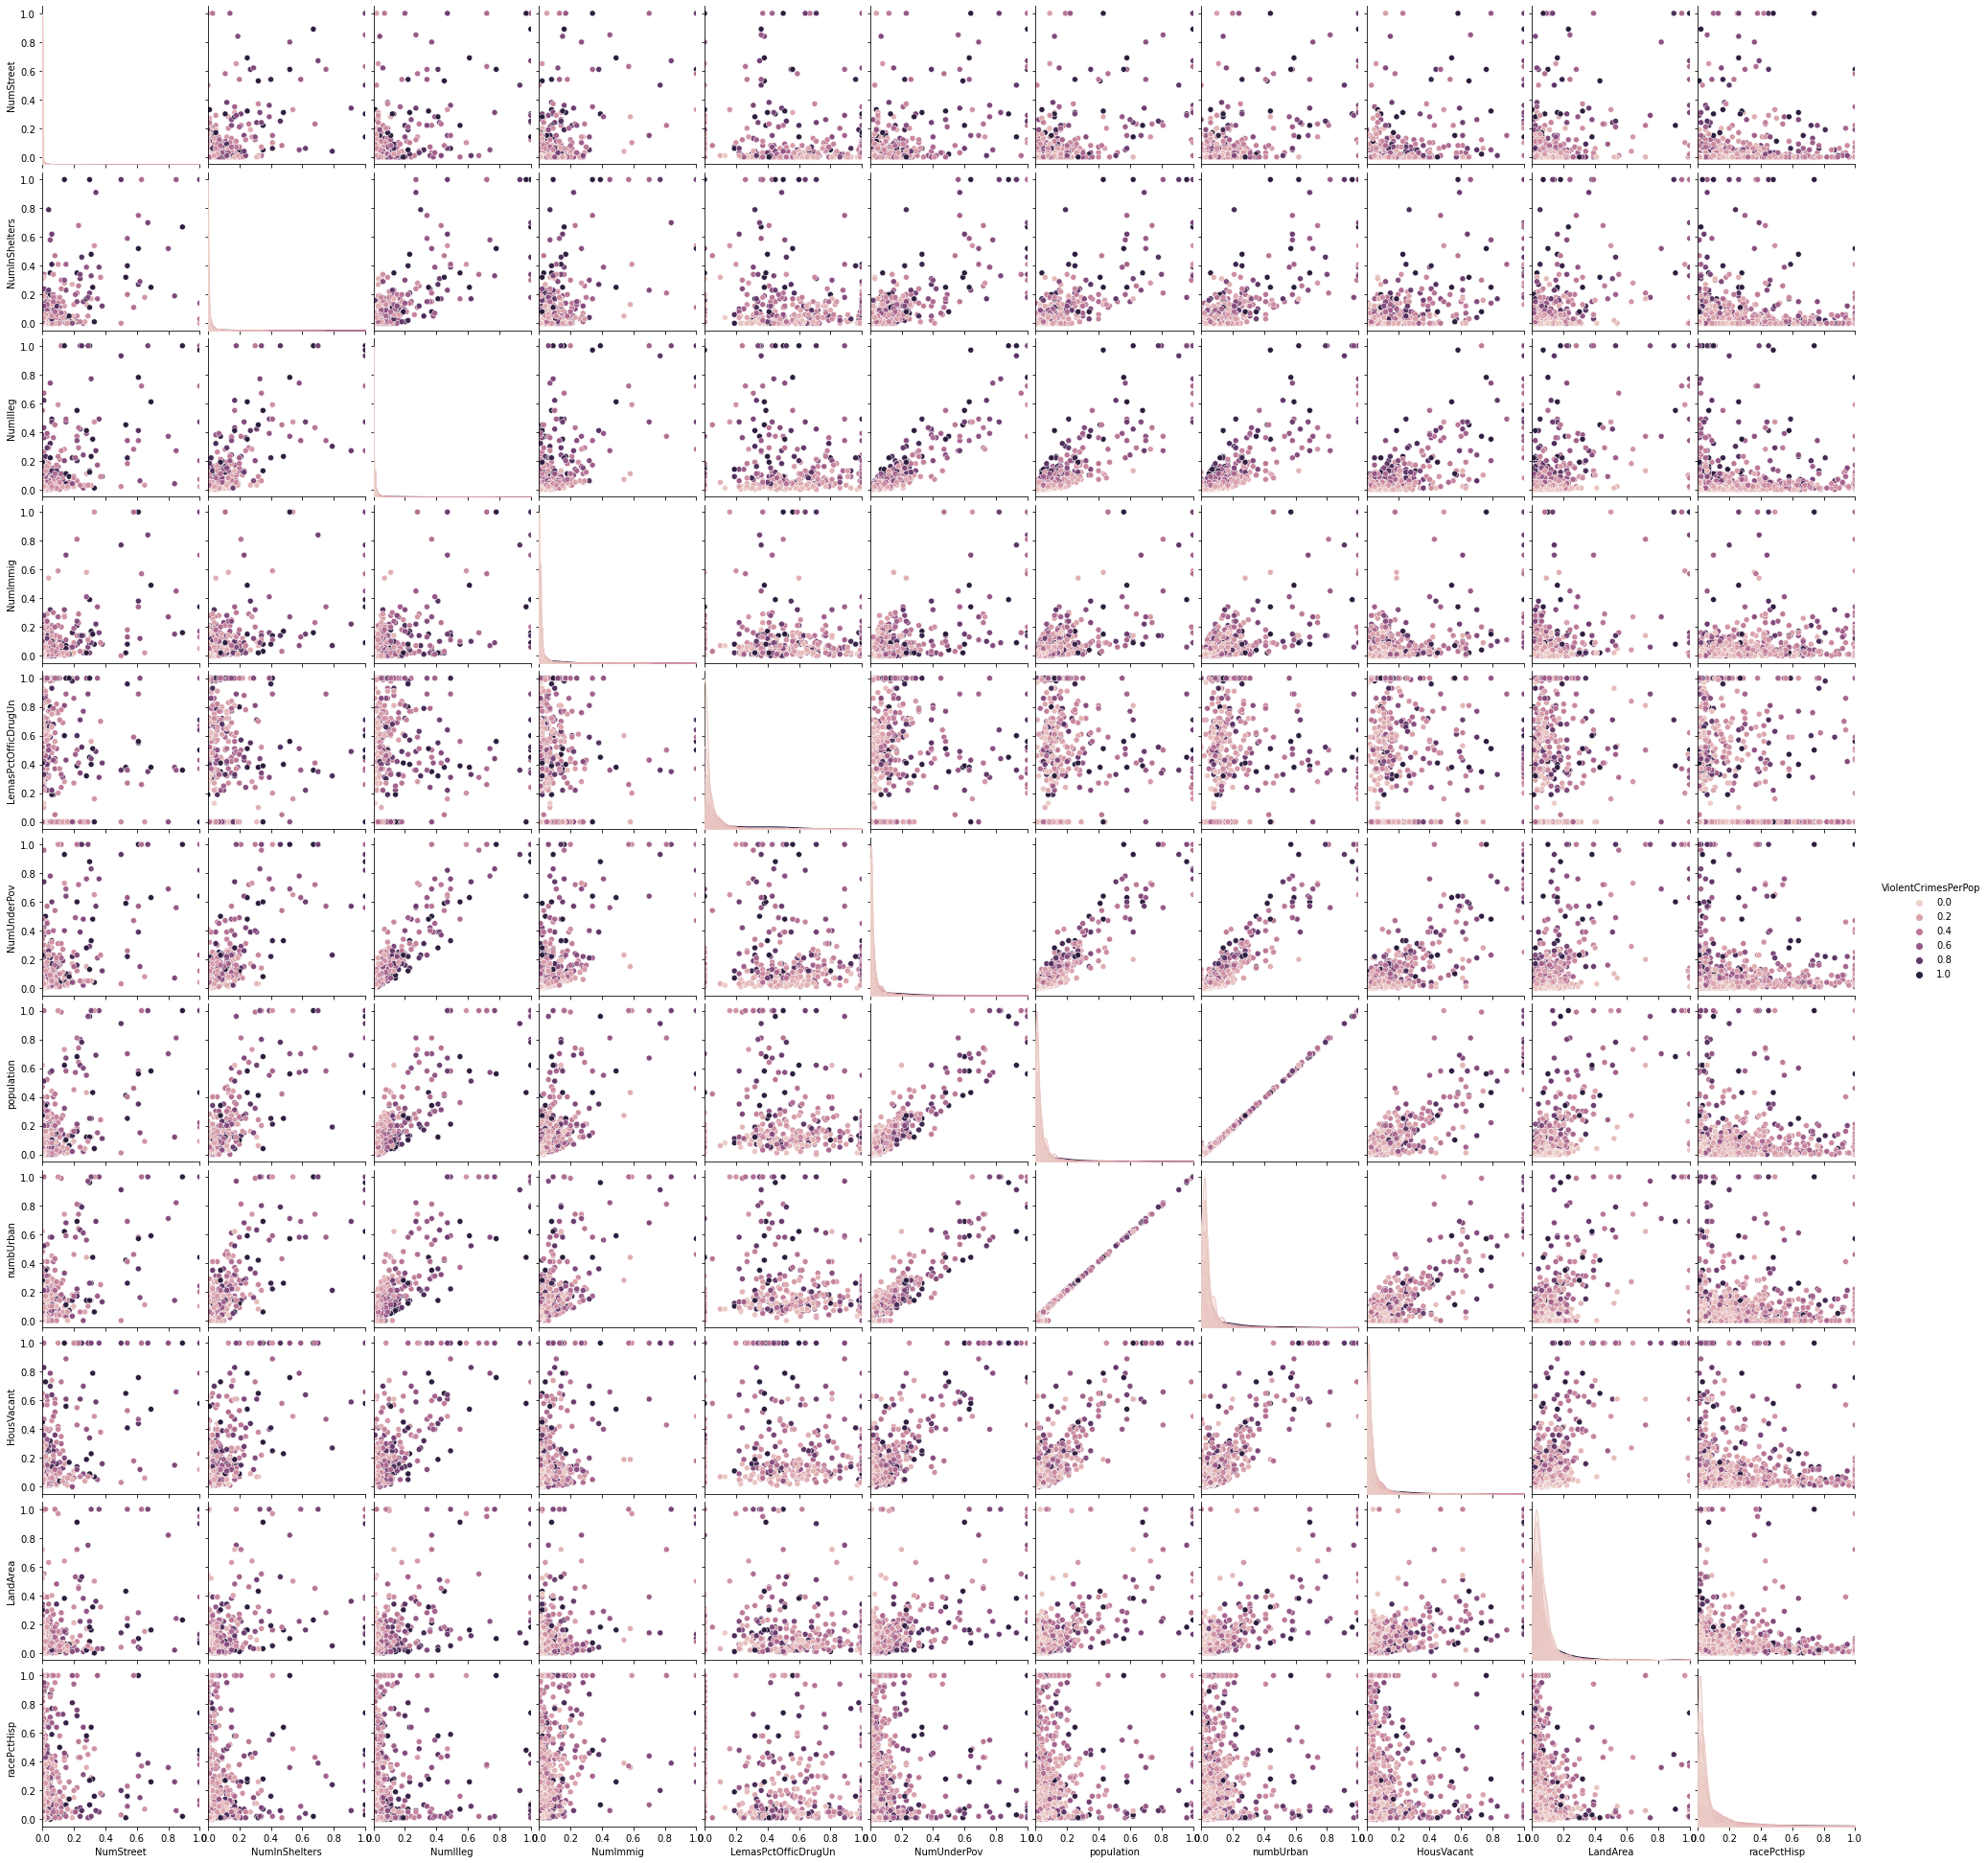

In [29]:
# pairplot of selected features
g = sns.pairplot(data = temp_merge, hue = 'ViolentCrimesPerPop')
g.set(xlim = (0, 1))
plt.show()


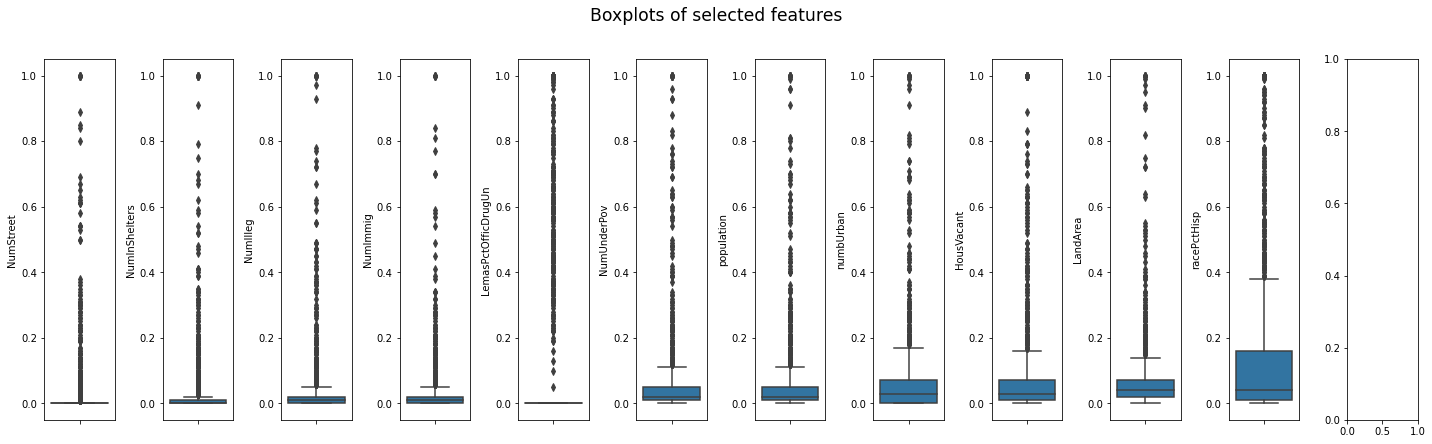

In [30]:
# boxplot of selected features

temp_df = df_crime_imp_X.loc[:, selected_features]

fig, ax = plt.subplots(1, 12, figsize = (20, 6))

for i, col in enumerate(temp_df):
    sns.boxplot(ax = ax[i], data = temp_df, y = col)

fig.suptitle('Boxplots of selected features', y = 1.02, fontsize = 'xx-large')
fig.tight_layout()    
plt.show()

> It's not very clear from the scatterplots how significant we can draw conclusions related to the target variable from the bivariate analysis. However, it seems like some of the selected features with high coefficient of variation shows a positive correlation to the label: the higher the feature value, the higher the response value. Moreover, it can be seen that two of the selected features, population and numbUrban, are highly correlated which might introduce collinearity when fitting the model.

### 2-f Fit a linear model using least squares to the training set and report the test error

In [31]:
# define final training dataset after preprocessing
df_crime_train_imp = impute_by_mean(df_crime_train_imp, df_crime_train)
train_X = df_crime_train_imp.loc[:, [col for col in df_crime_train_imp.columns if col not in ['state', 'county', 'community', 'communityname', 'fold', 'ViolentCrimesPerPop']]]
train_y = df_crime_train_imp.loc[:, 'ViolentCrimesPerPop']

# impute testing dataset based on training set & filter for selected features
df_crime_test_imp = impute_by_mean(df_crime_test, df_crime_train)
test_X = df_crime_test_imp.loc[:, [col for col in df_crime_train_imp.columns if col not in ['state', 'county', 'community', 'communityname', 'fold', 'ViolentCrimesPerPop']]]
test_y = df_crime_test_imp.loc[:, 'ViolentCrimesPerPop']


In [32]:
# train linear model
reg_lin = LinearRegression().fit(train_X, train_y)


In [33]:
# train and test MSE
print('Linear Regression Train MSE:', round(mean_squared_error(train_y, reg_lin.predict(train_X)), 4))
print('Linear Regression Test MSE:', round(mean_squared_error(test_y, reg_lin.predict(test_X)), 4))

Linear Regression Train MSE: 0.0163
Linear Regression Test MSE: 1.842018904333024e+18


> Test MSE is super high resulted from one of the coefficients in LinReg model using SKLearn has an extreme coefficient after training - coefficient for feature 'LemasSwFTPerPop' with a value of -3e+10

In [34]:
# using statsmodels to prune insignificant features

def sm_linear_regression(X_train, y_train):
    X_train_const = sm.add_constant(X_train)
    linreg = sm.OLS(y_train, X_train_const).fit()
    return linreg

reg_lin_sm = sm_linear_regression(train_X, train_y)
print(reg_lin_sm.summary())

                             OLS Regression Results                            
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.711
Model:                             OLS   Adj. R-squared:                  0.686
Method:                  Least Squares   F-statistic:                     27.94
Date:                 Fri, 25 Mar 2022   Prob (F-statistic):          6.56e-291
Time:                         22:21:45   Log-Likelihood:                 955.40
No. Observations:                 1495   AIC:                            -1667.
Df Residuals:                     1373   BIC:                            -1019.
Df Model:                          121                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [35]:
sig_features = train_X.columns[reg_lin_sm.pvalues[1:] < 0.05]
sig_features

Index(['racepctblack', 'pctUrban', 'pctWInvInc', 'pctWRetire',
       'PctPopUnderPov', 'PctEmploy', 'MalePctNevMarr', 'PctWorkMom',
       'PctNotSpeakEnglWell', 'PersPerRentOccHous', 'PctPersOwnOccup',
       'PctPersDenseHous', 'HousVacant', 'PctVacantBoarded', 'PctVacMore6Mos',
       'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctIncNoMtg',
       'NumStreet', 'PolicReqPerOffic', 'PctUsePubTrans',
       'LemasGangUnitDeploy'],
      dtype='object')

In [36]:
# train and test LinReg using SM again with significant features
reg_lin_sm_sig = sm_linear_regression(train_X.loc[:, sig_features], train_y)

# train and test MSE
print('Linear Regression Train MSE:', round(mean_squared_error(train_y, reg_lin_sm_sig.predict(sm.add_constant(train_X.loc[:, sig_features]))), 4))
print('Linear Regression Test MSE:', round(mean_squared_error(test_y, reg_lin_sm_sig.predict(sm.add_constant(test_X.loc[:, sig_features]))), 4))



Linear Regression Train MSE: 0.0193
Linear Regression Test MSE: 0.0202


### 2-g Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [37]:
# train Ridge regression
params = {'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]}
reg_ridge = Ridge()
reg_ridge_cv = GridSearchCV(reg_ridge, params, cv = 5, scoring = 'neg_mean_squared_error')
reg_ridge_cv.fit(train_X, train_y)


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             scoring='neg_mean_squared_error')

In [38]:
reg_ridge_cv.best_estimator_

Ridge(alpha=1)

In [39]:
# test error with best alpha = 1 from 5-fold CV
reg_ridge_best = Ridge(alpha = 1.0).fit(train_X, train_y)
print('Ridge Regression Test MSE:', round(mean_squared_error(test_y, reg_ridge_best.predict(test_X)), 4))

Ridge Regression Test MSE: 0.0177


> Lambda chosen from CV that gives best CV MSE is 1. Ridge regression error with lambda of 1 gives 0.0177 test MSE.

### 2-h Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized4 features. Report the test error for both cases and compare them.

In [40]:
# train Lasso regression
params = {'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]}
reg_lasso = Lasso()
reg_lasso_cv = GridSearchCV(reg_lasso, params, cv = 5, scoring = 'neg_mean_squared_error')
reg_lasso_cv.fit(train_X, train_y)


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             scoring='neg_mean_squared_error')

In [41]:
reg_lasso_cv.best_estimator_

Lasso(alpha=0.0001)

In [42]:
# test error with best alpha = 0.0001 from 5-fold CV
reg_lasso_best = Lasso(alpha = 0.0001).fit(train_X, train_y)
print('Lasso Regression Test MSE:', round(mean_squared_error(test_y, reg_lasso_best.predict(test_X)), 4))

Lasso Regression Test MSE: 0.0178


In [43]:
# List of features selected by Lasso (not shrunken)
train_X.loc[:, reg_lasso_best.coef_ != 0].columns

Index(['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29',
       'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc',
       'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap',
       'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap',
       'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy',
       'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr',
       'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par',
       'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10',
       'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup',
       'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous',
       'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup',
       'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt',
       'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ',
       'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc',
       'MedOwnCostPc

> Test MSE of Lasso model is 0.0178 which is similar to Ridge. There are a total of 78 features not shrunken.

#### standardize features

In [44]:
scaler = StandardScaler()
train_X_std = scaler.fit_transform(train_X)
test_X_std = scaler.transform(test_X)

In [45]:
# train Lasso regression
params = {'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]}
reg_lasso_std = Lasso(tol = 0.01)
reg_lasso_cv_std = GridSearchCV(reg_lasso_std, params, cv = 5, scoring = 'neg_mean_squared_error')
reg_lasso_cv_std.fit(train_X_std, train_y)


GridSearchCV(cv=5, estimator=Lasso(tol=0.01),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             scoring='neg_mean_squared_error')

In [46]:
reg_lasso_cv_std.best_estimator_

Lasso(alpha=0.001, tol=0.01)

In [47]:
# test error with best alpha = 0.001 from 5-fold CV
reg_lasso_std_best = Lasso(alpha = 0.001, tol = 0.01).fit(train_X_std, train_y)
print('Lasso Regression Test MSE (standardized features):', round(mean_squared_error(test_y, reg_lasso_std_best.predict(test_X_std)), 4))


Lasso Regression Test MSE (standardized features): 0.0178


In [48]:
# List of features selected by Lasso - standardized features (not shrunken)
train_X.loc[:, reg_lasso_std_best.coef_ != 0].columns

Index(['racepctblack', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage',
       'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire',
       'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap',
       'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade',
       'PctEmploy', 'PctEmplManu', 'MalePctDivorce', 'MalePctNevMarr',
       'FemalePctDiv', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par',
       'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig',
       'PctImmigRec5', 'PctRecImmig10', 'PctNotSpeakEnglWell',
       'PctLargHouseOccup', 'PctPersOwnOccup', 'PctPersDenseHous',
       'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded',
       'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb',
       'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc',
       'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn',
       'PctSameCity85', 'LemasSwFTFieldPerPop', 'Lem

> Test MSE of Lasso regression using standardized features is 0.0178 and there are 70 features selected (not shrunken)

### 2-i Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [49]:
# 5-fold CV to find m (number of principal components) to fit Linear Regression
params = {'pca__n_components' : range(1, 122)}
pipe = Pipeline(steps = 
                [('pca', PCA()), 
                 ("linreg", LinearRegression())])
pcr_cv = GridSearchCV(pipe, params, cv = 5, scoring = 'neg_mean_squared_error')
pcr_cv.fit(train_X, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 122)},
             scoring='neg_mean_squared_error')

In [50]:
pcr_cv.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=96)), ('linreg', LinearRegression())])

In [51]:
# best PCR model with m = 96
pcr_best = Pipeline(steps = 
                [('pca', PCA(n_components = 96)), 
                 ("linreg", LinearRegression())]).fit(train_X, train_y)
print('PCR (m = 96) Test MSE:', round(mean_squared_error(test_y, pcr_best.predict(test_X)), 4))

PCR (m = 96) Test MSE: 0.0185


> Using CV, number of components used is 96 components, and this gives a test MSE at 0.0185 when fitting the selected components to linear regression.

### 2-j In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [52]:
# train XGBoost L1-penalized regression tree
params = {'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]}
xgreg = xgb.XGBRegressor()
xgreg_cv = GridSearchCV(xgreg, params, cv = 5, scoring = 'neg_mean_squared_error')
xgreg_cv.fit(train_X, train_y)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [53]:
xgreg_cv.best_estimator_

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
# test error with best alpha = 1 from 5-fold CV
xgreg_best = xgb.XGBRegressor(alpha = 1).fit(train_X, train_y)
print('XGBoost L1-penalized Reg Tree Test MSE:', round(mean_squared_error(test_y, xgreg_best.predict(test_X)), 4))


XGBoost L1-penalized Reg Tree Test MSE: 0.0173


> Simple Linear Regression with feature selection seems to perform the worst while other algorithms give relatively the same level of test MSEs.

> Summary of test MSE from different methods:
> - Simple Linear Regression = 0.0202
> - Ridge = 0.0177
> - Lasso = 0.0178
> - Lasso (Standardized) = 0.0178
> - PCR = 0.0185
> - XGBoost = 0.0173